In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import torch.cuda.amp as amp
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Training Configuration
epochs = 5
batch_size = 1024 
lr = 3e-4
weight_decay = 0.01
device = "cuda"
checkpoint_filepath = None  # Set to a path if you want to load a checkpoint
save_dir = "checkpoints"
import os
os.makedirs(save_dir, exist_ok=True)

# Model code

In [3]:
class PatchEmbedding(nn.Module):
    """
    Module that converts image patches to embeddings for Vision Transformer.
    """
    def __init__(self,
                 image_size: tuple = (64, 72),
                 patch_size: int = 8,
                 in_channels: int = 3,
                 embedding_dim: int = 1024):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels

        # Calculate number of patches
        self.num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)

        # Create projection for converting patches to embeddings
        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # CLS token embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))

        # Positional embedding (Normal distribution initialization of value)
        self.positions = nn.Parameter(torch.zeros(1, self.num_patches + 1, embedding_dim))
        nn.init.trunc_normal_(self.positions, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]

        # Convert image to patches and project to embedding dimension
        # x shape: [batch_size, channels, height, width]
        x = self.projection(x)
        # x shape: [batch_size, embedding_dim, height/patch_size, width/patch_size]

        # Flatten patches to sequence
        x = x.flatten(2).transpose(1, 2)
        # x shape: [batch_size, num_patches, embedding_dim]

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embeddings
        x = x + self.positions

        return x


class VisionAttention(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 head_dim: int,
                 q_head: int,
                 kv_head: int,
                 lora_rank: int = 16):
        super().__init__()
        self.head_dim = head_dim
        self.q_head = q_head
        self.kv_head = kv_head
        self.qkv = nn.Linear(hidden_dim, (q_head+kv_head*2)*head_dim)
        self.o = nn.Linear(q_head*head_dim, hidden_dim)
        self.scaler = 1/math.sqrt(head_dim)
        self.lora_qkv_a = nn.Linear(hidden_dim, lora_rank)
        self.lora_qkv_b = nn.Linear(lora_rank, (q_head+kv_head*2)*head_dim)
        self.lora_o_a = nn.Linear(q_head*head_dim, lora_rank)
        self.lora_o_b = nn.Linear(lora_rank, hidden_dim)

        if q_head != kv_head:
            # If we are using multi query attention
            assert q_head % kv_head == 0
            self.multi_query_attention = True
            self.q_kv_scale = q_head//kv_head
        else:
            self.multi_query_attention = False

    def forward(self, tensor: torch.Tensor, attention_mask: torch.Tensor = None, fine_tuning: bool = False) -> torch.Tensor:
        batch_size, seq_len, hid_dim = tensor.shape

        qkv_tensor = self.qkv(tensor)
        if fine_tuning:
            lora_tensor = self.lora_qkv_a(tensor)
            lora_tensor = self.lora_qkv_b(lora_tensor)
            qkv_tensor = lora_tensor + qkv_tensor
        query, key, value = qkv_tensor.split([self.head_dim*self.q_head, self.head_dim*self.kv_head, self.head_dim*self.kv_head], dim=-1)

        query = query.view(batch_size, seq_len, self.q_head, self.head_dim)
        key = key.view(batch_size, seq_len, self.kv_head, self.head_dim)
        value = value.view(batch_size, seq_len, self.kv_head, self.head_dim)

        if self.multi_query_attention:
            # If we are using multi query attention, duplicate key value heads
            key = torch.repeat_interleave(key, self.q_kv_scale, dim=-2)
            value = torch.repeat_interleave(value, self.q_kv_scale, dim=-2)

        # Switch to batch_size, head, seq_len, head_dim
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Classic self attention
        attention_raw = torch.matmul(query, key.transpose(2, 3))
        attention_scaled = attention_raw * self.scaler
        if attention_mask != None:
            attention_scaled += attention_mask
        attention_score = torch.softmax(attention_scaled, dim=-1)
        value = torch.matmul(attention_score, value)

        # Reshape back to batch_size, seq_len, hid_dim
        value = value.transpose(1, 2).contiguous()
        value = value.view(batch_size, seq_len, hid_dim)

        # Output layer
        output = self.o(value)
        if fine_tuning:
            lora_tensor = self.lora_o_a(value)
            lora_tensor = self.lora_o_b(lora_tensor)
            output = lora_tensor + output

        return output


class FeedForward(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 expansion_factor: int = 4,
                 dropout_ratio: float = 0.1,
                 lora_rank: int = 16):
        super().__init__()
        self.gate_and_up = nn.Linear(hidden_size, hidden_size * expansion_factor * 2)
        self.down = nn.Linear(hidden_size * expansion_factor, hidden_size)
        self.dropout = nn.Dropout(p=dropout_ratio)
        self.lora_gate_and_up_a = nn.Linear(hidden_size, lora_rank)
        self.lora_gate_and_up_b = nn.Linear(lora_rank, hidden_size * expansion_factor * 2)
        self.lora_down_a = nn.Linear(hidden_size * expansion_factor, lora_rank)
        self.lora_down_b = nn.Linear(lora_rank, hidden_size)

    def forward(self, tensor: torch.Tensor, fine_tuning: bool = False) -> torch.Tensor:
        gate_and_up = self.gate_and_up(tensor)
        if fine_tuning:
            lora_tensor = self.lora_gate_and_up_a(tensor)
            lora_tensor = self.lora_gate_and_up_b(lora_tensor)
            gate_and_up = gate_and_up + lora_tensor
        gate, up = gate_and_up.chunk(chunks=2, dim=-1)
        gate = F.gelu(gate, approximate="tanh")
        tensor = gate * up
        tensor = self.dropout(tensor)
        down_tensor = self.down(tensor)
        if fine_tuning:
            lora_tensor = self.lora_down_a(tensor)
            lora_tensor = self.lora_down_b(lora_tensor)
            down_tensor = down_tensor + lora_tensor
        return down_tensor


class MOE(nn.Module):
    def __init__(self, hidden_size: int, device: str, num_experts: int = 8, expansion_factor: int = 4, dropout_ratio: float = 0.1, lora_rank: int = 16):
        super().__init__()
        self.gate = nn.Linear(hidden_size, num_experts)
        self.num_experts = num_experts
        self.device = device
        self.experts = nn.ModuleList([FeedForward(hidden_size, expansion_factor=expansion_factor, dropout_ratio=dropout_ratio, lora_rank=lora_rank) for _ in range(num_experts)])

    def forward(self, tensor: torch.Tensor, fine_tuning: bool = False) -> tuple[torch.Tensor, torch.Tensor]:
        # Flatten for better manipulation, this is ok because tokens are independent at this stage
        batch_size, seq_len, hidden_size = tensor.shape
        flat_tensor = tensor.reshape(batch_size * seq_len, hidden_size)

        # Pass through the gating network and select experts
        tensor = self.gate(flat_tensor)
        tensor = F.softmax(tensor, dim=-1)

        # The output of this step is a tensor of shape [batch_size * seq_len, 2] with element i in the second dimension representing ith expert selected for this token
        value_tensor, index_tensor = tensor.topk(k=2, dim=-1)

        # Find the load balancing loss
        counts = torch.bincount(index_tensor[:, 0], minlength=self.num_experts)
        frequencies = counts.float() / (batch_size * seq_len) # This is the hard one-hot frequency
        probability = tensor.mean(0) # This is the soft probability
        load_balancing_loss = (probability * frequencies).mean() * float(self.num_experts ** 2)

        # Normalize top1 and top2 score
        top_expert_score = value_tensor[:, 0]
        second_expert_score = value_tensor[:, 1]
        total_score = top_expert_score + second_expert_score
        top_expert_score = top_expert_score / total_score
        second_expert_score = second_expert_score / total_score

        # Split into top 2 experts
        split_tensors = torch.split(index_tensor, 1, dim=-1)
        top_expert, second_expert = split_tensors[0], split_tensors[1]
        indices = torch.arange(batch_size * seq_len).unsqueeze(-1).to(self.device)
        top_expert = torch.cat((indices, top_expert), dim=-1)
        second_expert = torch.cat((indices, second_expert), dim=-1)

        # Sort based on expert selection
        top_expert = top_expert[top_expert[:,1].argsort()]
        second_expert = second_expert[second_expert[:,1].argsort()]

        # Count how many tokens goes to each expert
        top_expert_counts = torch.zeros(self.num_experts, dtype=int)
        for i in range(self.num_experts):
            top_expert_counts[i] = (top_expert[:,1] == i).sum()
        top_expert_counts = top_expert_counts.tolist()

        second_expert_counts = torch.zeros(self.num_experts, dtype=int)
        for i in range(self.num_experts):
            second_expert_counts[i] = (second_expert[:,1] == i).sum()
        second_expert_counts = second_expert_counts.tolist()

        # Split input tokens for each expert
        top_expert_tokens = flat_tensor[top_expert[:,0]]
        second_expert_tokens = flat_tensor[second_expert[:,0]]

        # Split into a list of tensors, element i tensor is for ith expert.
        top_expert_tokens = torch.split(top_expert_tokens, top_expert_counts, dim=0)
        second_expert_tokens = torch.split(second_expert_tokens, second_expert_counts, dim=0)

        # Input into each expert and obtain results in a list
        top_expert_outputs = [self.experts[i](top_expert_tokens[i], fine_tuning) if top_expert_counts[i] > 0 else torch.zeros(0, hidden_size, dtype=torch.float16).to(self.device) for i in range(self.num_experts)]
        second_expert_outputs = [self.experts[i](second_expert_tokens[i], fine_tuning) if second_expert_counts[i] > 0 else torch.zeros(0, hidden_size, dtype=torch.float16).to(self.device) for i in range(self.num_experts)]

        # Combine outputs
        top_expert_outputs = torch.cat(top_expert_outputs, dim=0)
        second_expert_outputs = torch.cat(second_expert_outputs, dim=0)

        # Re-index the output back to original token order
        flat_top_expert_tensor = torch.zeros_like(flat_tensor, dtype=torch.float16).to(self.device)
        flat_top_expert_tensor.index_copy_(0, top_expert[:, 0], top_expert_outputs)

        flat_second_expert_tensor = torch.zeros_like(flat_tensor, dtype=torch.float16).to(self.device)
        flat_second_expert_tensor.index_copy_(0, second_expert[:, 0], second_expert_outputs)

        # Find final output tensor based on weight between top and second expert
        final_tensor = top_expert_score.unsqueeze(-1) * flat_top_expert_tensor + second_expert_score.unsqueeze(-1) * flat_second_expert_tensor

        # Reshape to original [batch_size, seq_len, hidden_size]
        final_tensor = final_tensor.reshape(batch_size, seq_len, hidden_size)

        return final_tensor, load_balancing_loss


class VisionLayer(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 head_dim: int,
                 q_head: int,
                 kv_head: int,
                 device: str,
                 expansion_factor: int = 4,
                 dropout_ratio: float = 0.1,
                 use_moe: bool = False,
                 num_experts: int = 8,
                 lora_rank: int = 16):
        super().__init__()
        self.use_moe = use_moe
        self.device = device

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.attention = VisionAttention(hidden_dim, head_dim, q_head, kv_head, lora_rank=lora_rank)

        self.norm2 = nn.LayerNorm(hidden_dim)
        if self.use_moe:
            self.moe = MOE(hidden_dim, device, num_experts=num_experts, expansion_factor=expansion_factor,
                           dropout_ratio=dropout_ratio, lora_rank=lora_rank)
        else:
            self.ffn = FeedForward(hidden_dim, expansion_factor=expansion_factor, dropout_ratio=dropout_ratio,
                                  lora_rank=lora_rank)

    def forward(self, tensor: torch.Tensor, attention_mask: torch.Tensor = None, fine_tuning: bool = False):
        skip_connection = tensor
        tensor = self.norm1(tensor)
        tensor = self.attention(tensor, attention_mask=attention_mask, fine_tuning=fine_tuning)
        tensor += skip_connection

        skip_connection = tensor
        tensor = self.norm2(tensor)
        if self.use_moe:
            tensor, load_balancing_loss = self.moe(tensor, fine_tuning=fine_tuning)
        else:
            tensor = self.ffn(tensor, fine_tuning=fine_tuning)
            load_balancing_loss = torch.tensor(0.0, dtype=tensor.dtype, device=self.device)

        tensor += skip_connection

        return tensor, load_balancing_loss


class VisionTransformer(nn.Module):
    def __init__(self,
                 image_size: tuple,
                 num_classes: int = 1,
                 patch_size: int = 8,
                 in_channels: int = 3,
                 num_layer: int = 3,
                 hidden_dim: int = 1024,
                 expansion_factor: int = 8,
                 head_dim: int = 64,
                 q_head: int = 16,
                 kv_head: int = 4,
                 dropout_ratio: float = 0.1,
                 use_moe: bool = True,
                 num_experts: int = 8,
                 load_balancing_loss_weight: float = 1e-2,
                 fine_tuning: bool = False,
                 lora_rank: int = 16):
        super().__init__()
        self.device = device
        self.num_layer = num_layer
        self.load_balancing_loss_weight = load_balancing_loss_weight
        self.fine_tuning = fine_tuning

        # Patch embedding
        self.patch_embedding = PatchEmbedding(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embedding_dim=hidden_dim
        )

        # Calculate number of patches (sequence length)
        self.num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size) + 1  # +1 for cls token

        if q_head == None:
            q_head = (hidden_dim // head_dim)

        if kv_head == None:
            kv_head = (hidden_dim // head_dim)

        if hidden_dim % (head_dim * q_head) != 0 or hidden_dim % (head_dim * kv_head):
            raise ValueError("Error: hidden_dim or projection_dim (if specified) must be divisible by the product of the number of q or kv heads and the head dimension.")

        # Create transformer layers
        self.transformer = nn.ModuleList()
        for _ in range(self.num_layer):
            self.transformer.append(VisionLayer(
                hidden_dim, head_dim, q_head, kv_head, device,
                expansion_factor=expansion_factor,
                dropout_ratio=dropout_ratio,
                use_moe=use_moe,
                num_experts=num_experts,
                lora_rank=lora_rank
            ))
        self.output_norm = nn.LayerNorm(hidden_dim)

        # Final classifier head
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def begin_fine_tunning(self) -> None:
        self.fine_tuning = True
        for name, param in self.named_parameters():
            if "lora" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def exit_fine_tunning(self) -> None:
        self.fine_tuning = False
        for name, param in self.named_parameters():
            if "positions" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Handle input shape
        if len(x.shape) == 3:  # [batch_size, 64, 72]
            # Reshape to [batch_size, channels, height, width]
            # Assuming the input is grayscale (1 channel)
            batch_size, height, width = x.shape
            x = x.unsqueeze(1)  # Add channel dimension [batch_size, 1, 64, 72]

        # Apply patch embedding
        x = self.patch_embedding(x)

        # Track load-balancing across layers (only if MoE is used)
        load_balancing_sum = torch.tensor(0.0, device=self.device)

        # Pass through transformer layers
        for layer in self.transformer:
            x, load_balancing_loss = layer(x, fine_tuning=self.fine_tuning)
            load_balancing_sum += load_balancing_loss

        load_balancing_loss = (load_balancing_sum / self.num_layer) * self.load_balancing_loss_weight

        # Apply output normalization
        x = self.output_norm(x)

        # Use CLS token for classification
        x = x[:, 0]  # Take only the CLS token

        # Apply classifier
        x = self.classifier(x)

        return x, load_balancing_loss

# Preprocessing Data

In [4]:
data0 = np.load('Run357479_Dataset_iodic.npy')
data1 = np.load('Run355456_Dataset_jqkne.npy')

# Create labels: 0 for class 0 and 1 for class 1
labels_0 = np.zeros((data0.shape[0],), dtype=np.int32)
labels_1 = np.ones((data1.shape[0],), dtype=np.int32)

# Concatenate data and labels
data = np.concatenate([data0, data1], axis=0)  # Shape (20000, 64, 72)
labels = np.concatenate([labels_0, labels_1], axis=0)  # Shape (20000,)

# Shuffle data and labels together
indices = np.random.permutation(data.shape[0])
data = data[indices]
labels = labels[indices]

# Seperate into training, validation and testing set.
n_total = data.shape[0]
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

train_data, val_data, test_data = data[:n_train], data[n_train:n_train + n_val], data[n_train + n_val:]
train_labels, val_labels, test_labels = labels[:n_train], labels[n_train:n_train + n_val], labels[n_train + n_val:]

# Compute mean and std from the training data only
mean = train_data.mean()
std = train_data.std()

# Apply the same transformation to train, val, test
train_data = (train_data - mean) / (std + 1e-7)
val_data = (val_data - mean) / (std + 1e-7)
test_data = (test_data - mean) / (std + 1e-7)

# Convert to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
val_data_tensor = torch.tensor(val_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create PyTorch DataLoaders
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor.float().unsqueeze(1))
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor.float().unsqueeze(1))
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor.float().unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Preparing for training

In [5]:
# Checkpoint loading
def load_checkpoint(model, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_loss = checkpoint.get('validation_loss', float('inf'))
    print(f"Loaded checkpoint from epoch {epoch} with validation loss {validation_loss:.6f}")
    return epoch

# Checkpoint saving
def save_checkpoint(model, optimizer, epoch, validation_loss):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'validation_loss': validation_loss
    }
    torch.save(checkpoint, f"{save_dir}/vit_checkpoint_epoch_{epoch}.pt")
    # Save best model separately
    if epoch == 0 or validation_loss < min(loss_valid):
        torch.save(checkpoint, f"{save_dir}/vit_best_model.pt")
        print(f"Saved best model with validation loss: {validation_loss:.6f}")

In [6]:
vit = VisionTransformer(
    image_size=(64, 72),    # Your input image dimensions
    patch_size=8,           # Size of each patch
    in_channels=1,          # We technically don't have channel value here.
    num_classes=1,          # Number of output classes
    num_layer=3,            # Number of transformer layers
    hidden_dim=256,        # Hidden dimension
    expansion_factor=4,     # Expansion factor for FFN
    head_dim=64,            # Dimension of each attention head
    q_head=4,              # Number of query heads
    kv_head=1,              # Number of key/value heads
    use_moe=True,           # Whether to use Mixture of Experts
    num_experts=4
).to(device)

# Load checkpoint if available
current_epoch = 0
if checkpoint_filepath is not None and checkpoint_filepath != "":
    current_epoch = load_checkpoint(vit, optimizer, checkpoint_filepath) + 1

print(f"This model has {sum(p.numel() for p in vit.parameters())} parameters.")
print(f"Training on {device}")

This model has 10774253 parameters.
Training on cuda


In [7]:
# Binary classification loss since num_classes=1
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(train_loader), eta_min=1e-5)
scaler = amp.GradScaler() # Initialize gradient scaler for mixed precision training

In [8]:
# Initialize loss tracking lists
loss_train = []
loss_valid = []
accuracy_train = []
accuracy_valid = []

# Training

In [9]:
# Training loop
for epoch in range(current_epoch, epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training phase
    vit.train()
    loss_train_epoch = []
    correct_train = 0
    total_train = 0
    
    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        
        # Forward pass with mixed precision
        with amp.autocast():
            outputs, load_balancing_loss = vit(inputs)
            loss = criterion(outputs, targets) + load_balancing_loss
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(vit.parameters(), max_norm=1.0)
        
        # Optimizer step with scaler
        scaler.step(optimizer)
        scaler.update()
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Update scheduler
        scheduler.step()
        
        # Record loss
        loss_train_epoch.append(loss.item())
        
        # Calculate accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
    
    # Calculate epoch statistics
    epoch_loss = np.mean(loss_train_epoch)
    epoch_accuracy = 100 * correct_train / total_train
    loss_train.append(epoch_loss)
    accuracy_train.append(epoch_accuracy)
    
    # Validation phase
    vit.eval()
    loss_val_epoch = []
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            
            # Forward pass
            with amp.autocast():
                outputs, load_balancing_loss = vit(inputs)
                loss = criterion(outputs, targets) + load_balancing_loss
            
            # Record loss
            loss_val_epoch.append(loss.item())
            
            # Calculate accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
    
    # Calculate epoch validation statistics
    epoch_val_loss = np.mean(loss_val_epoch)
    epoch_val_accuracy = 100 * correct_val / total_val
    loss_valid.append(epoch_val_loss)
    accuracy_valid.append(epoch_val_accuracy)
    
    # Print epoch results
    print(f"Training - Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation - Loss: {epoch_val_loss:.6f}, Accuracy: {epoch_val_accuracy:.2f}%")
    
    # Plot and save training progress
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label="Training loss")
    plt.plot(loss_valid, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_train, label="Training accuracy")
    plt.plot(accuracy_valid, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/training_progress_epoch_{epoch}.png")
    plt.close()

# Save checkpoint
save_checkpoint(vit, optimizer, epoch, epoch_val_loss)

Epoch 1/5


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Training - Loss: 0.579171, Accuracy: 74.58%
Validation - Loss: 0.027781, Accuracy: 99.70%
Epoch 2/5


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Training - Loss: 0.016199, Accuracy: 99.88%
Validation - Loss: 0.010464, Accuracy: 100.00%
Epoch 3/5


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Training - Loss: 0.010416, Accuracy: 100.00%
Validation - Loss: 0.010539, Accuracy: 100.00%
Epoch 4/5


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Training - Loss: 0.010518, Accuracy: 100.00%
Validation - Loss: 0.010374, Accuracy: 100.00%
Epoch 5/5


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


Training - Loss: 0.010164, Accuracy: 100.00%
Validation - Loss: 0.010069, Accuracy: 100.00%



Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

Test set - Loss: 0.010067, Accuracy: 100.00%
AUC: 1.0000


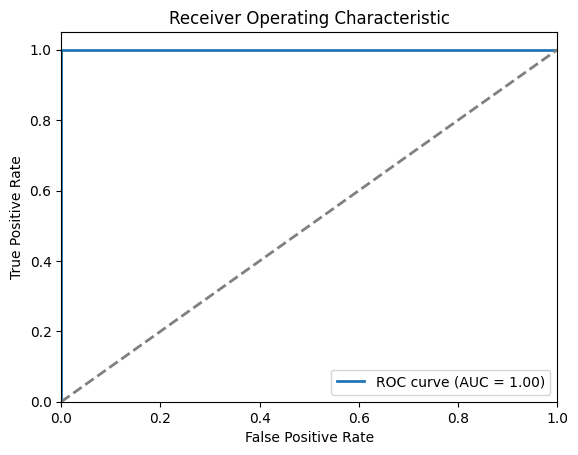

Test completed!


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Lists to store true labels and predicted probabilities
all_targets = []
all_probs = []

print("\nEvaluating on test set...")
vit.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        with amp.autocast():
            outputs, load_balancing_loss = vit(inputs)
            loss = criterion(outputs, targets) + load_balancing_loss
        
        test_loss += loss.item()
        # Compute probabilities using sigmoid
        probabilities = torch.sigmoid(outputs)
        # Calculate binary predictions for accuracy
        predicted = (probabilities > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Append to lists (move to CPU and convert to numpy)
        all_targets.append(targets.cpu().numpy())
        all_probs.append(probabilities.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test set - Loss: {avg_test_loss:.6f}, Accuracy: {test_accuracy:.2f}%")

# Concatenate all the batches
all_targets = np.concatenate(all_targets)
all_probs = np.concatenate(all_probs)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)
print("AUC: {:.4f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save final model
torch.save({
    'model_state_dict': vit.state_dict(),
    'test_accuracy': test_accuracy,
    'test_loss': avg_test_loss
}, f"{save_dir}/vit_final_model.pt")

print("Test completed!")


In [ ]:
# Code for visualization of training data, not used in actual training but kept here for your reference
non_zero_values = data1[data1 != 0]

# Calculate statistics
min_non_zero = np.min(non_zero_values)
max_non_zero = np.max(non_zero_values)
mean_non_zero = np.mean(non_zero_values)
median_non_zero = np.median(non_zero_values)
std_non_zero = np.std(non_zero_values)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Histogram with KDE
sns.histplot(non_zero_values, kde=True, ax=ax1)
ax1.set_title('Distribution of Non-Zero Values', fontsize=14)
ax1.set_xlabel('Value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(min_non_zero, color='r', linestyle='--', label=f'Min: {min_non_zero:.2f}')
ax1.axvline(max_non_zero, color='g', linestyle='--', label=f'Max: {max_non_zero:.2f}')
ax1.axvline(mean_non_zero, color='b', linestyle='-', label=f'Mean: {mean_non_zero:.2f}')
ax1.axvline(median_non_zero, color='purple', linestyle='-.', label=f'Median: {median_non_zero:.2f}')
ax1.legend()

# Boxplot
sns.boxplot(x=non_zero_values, ax=ax2)
ax2.set_title('Boxplot of Non-Zero Values', fontsize=14)
ax2.set_xlabel('Value', fontsize=12)

# Add text with statistics
stats_text = (f"Non-zero count: {len(non_zero_values)}\n"
              f"Min: {min_non_zero:.2f}\n"
              f"Max: {max_non_zero:.2f}\n"
              f"Mean: {mean_non_zero:.2f}\n"
              f"Median: {median_non_zero:.2f}\n"
              f"Std Dev: {std_non_zero:.2f}")

fig.text(0.15, 0.01, stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('non_zero_distribution.png')
plt.show()

# Print summary to console
print(f"Non-zero value summary:")
print(f"Count: {len(non_zero_values)}")
print(f"Min: {min_non_zero:.2f}")
print(f"Max: {max_non_zero:.2f}")
print(f"Mean: {mean_non_zero:.2f}")
print(f"Median: {median_non_zero:.2f}")
print(f"Standard deviation: {np.std(non_zero_values):.2f}")